<a href="https://colab.research.google.com/github/Disha-Sikka/FineTune_and_GradCam/blob/main/FineTune_%26_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 94% 324M/346M [00:00<00:00, 708MB/s]
100% 346M/346M [00:00<00:00, 711MB/s]


In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [8]:
train_dataset= datasets.ImageFolder('seg_train/seg_train', transform=transform)
test_dataset= datasets.ImageFolder('seg_test/seg_test', transform=transform)

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32)


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

In [10]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= models.resnet18(pretrained= True)
num_ftrs= model.fc.in_features
model.fc= nn.Linear(num_ftrs,6)
model= model.to(device)
print(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


cuda


In [11]:
import torch.optim as optim
import os
from tqdm import tqdm

In [12]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)
os.makedirs('checkpoints', exist_ok=True)

for epochs in range(10):
  model.train()
  running_loss=0
  correct=0
  total=0

  for images, labels in tqdm(train_loader, desc=f"Epoch {epochs+1}/{10}"):
    images, labels= images.to(device), labels.to(device)
    outputs= model(images)
    loss= criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss+= loss.item()
    _, predicted= outputs.max(1)
    total += labels.size(0)
    correct+= (predicted==labels).sum().item()

  train_loss= running_loss/ len(train_loader)
  train_acc= 100* correct/total
  print(f"Epoch [{epochs+1}/10], Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}")
  checkpoint_path = f"checkpoints/resnet18_epoch{epochs+1}.pt"
  torch.save({
      'epoch': epochs+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_loss': train_loss,
      'train_acc': train_acc,
  }, checkpoint_path)
  print(f"✅ Checkpoint saved: {checkpoint_path}")



Epoch 1/10: 100%|██████████| 439/439 [01:11<00:00,  6.16it/s]


Epoch [1/10], Accuracy: 83.28, Loss: 0.4757
✅ Checkpoint saved: checkpoints/resnet18_epoch1.pt


Epoch 2/10: 100%|██████████| 439/439 [01:06<00:00,  6.59it/s]


Epoch [2/10], Accuracy: 88.39, Loss: 0.3321
✅ Checkpoint saved: checkpoints/resnet18_epoch2.pt


Epoch 3/10: 100%|██████████| 439/439 [01:06<00:00,  6.58it/s]


Epoch [3/10], Accuracy: 90.07, Loss: 0.2904
✅ Checkpoint saved: checkpoints/resnet18_epoch3.pt


Epoch 4/10: 100%|██████████| 439/439 [01:06<00:00,  6.61it/s]


Epoch [4/10], Accuracy: 91.31, Loss: 0.2479
✅ Checkpoint saved: checkpoints/resnet18_epoch4.pt


Epoch 5/10: 100%|██████████| 439/439 [01:06<00:00,  6.55it/s]


Epoch [5/10], Accuracy: 92.66, Loss: 0.2098
✅ Checkpoint saved: checkpoints/resnet18_epoch5.pt


Epoch 6/10: 100%|██████████| 439/439 [01:06<00:00,  6.58it/s]


Epoch [6/10], Accuracy: 93.44, Loss: 0.1893
✅ Checkpoint saved: checkpoints/resnet18_epoch6.pt


Epoch 7/10: 100%|██████████| 439/439 [01:07<00:00,  6.54it/s]


Epoch [7/10], Accuracy: 94.76, Loss: 0.1504
✅ Checkpoint saved: checkpoints/resnet18_epoch7.pt


Epoch 8/10: 100%|██████████| 439/439 [01:06<00:00,  6.59it/s]


Epoch [8/10], Accuracy: 95.12, Loss: 0.1367
✅ Checkpoint saved: checkpoints/resnet18_epoch8.pt


Epoch 9/10: 100%|██████████| 439/439 [01:07<00:00,  6.52it/s]


Epoch [9/10], Accuracy: 96.03, Loss: 0.1175
✅ Checkpoint saved: checkpoints/resnet18_epoch9.pt


Epoch 10/10: 100%|██████████| 439/439 [01:07<00:00,  6.52it/s]


Epoch [10/10], Accuracy: 96.78, Loss: 0.0934
✅ Checkpoint saved: checkpoints/resnet18_epoch10.pt


In [13]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [14]:
class GradCAM:
  def __init__(self, model, target_layer):
    self.model= model
    self.target_layer= target_layer
    self.gradients=None
    self.activations= None
    self._register_hooks()

  def _register_hooks(self):
    def forward_hook(module, input, output):
      self.activations= output.detach()
    def backward_hook(module, grad_in, grad_out):
      self.gradients= grad_out[0].detach()

    self.target_layer.register_forward_hook(forward_hook)
    self.target_layer.register_backward_hook(backward_hook)

  def generate_heatmap(self, input_tensor, class_idx=None):
    self.model.eval()
    output= self.model(input_tensor)

    if class_idx is None:
      class_idx= torch.argmax(output)

    self.model.zero_grad()
    output[0, class_idx].backward()

    pooled_gradients= torch.mean(self.gradients, dim=[0,2,3])
    activations= self.activations[0]

    for i in range(activations.shape[0]):
      activations[i]*=pooled_gradients[i]

    heatmap=torch.mean(activations, dim=0).cpu()
    heatmap=np.maximum(heatmap,0)
    heatmap /= torch.max(heatmap)

    return heatmap.numpy()


In [15]:
def show_gradcam_on_image(img_tensor, heatmap, alpha=0.4):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = heatmap_color / 255.0  # Normalize to [0, 1]

    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

🖼️ Image 1 | True Label: 2 | Predicted: 2


/tmp/ipython-input-14-342213017.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap=np.maximum(heatmap,0)


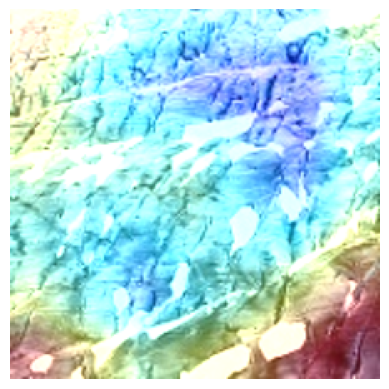

🖼️ Image 2 | True Label: 5 | Predicted: 5


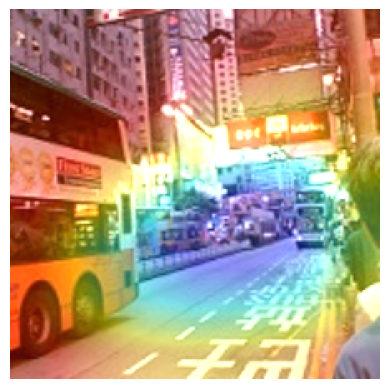

🖼️ Image 3 | True Label: 5 | Predicted: 5


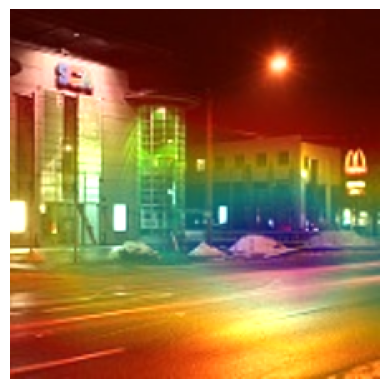

🖼️ Image 4 | True Label: 1 | Predicted: 4


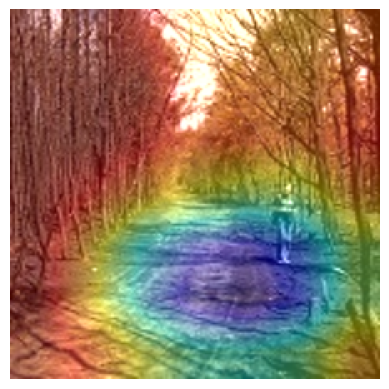

🖼️ Image 5 | True Label: 0 | Predicted: 0


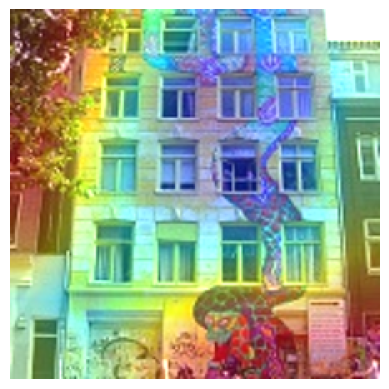

In [19]:
import random

gradcam = GradCAM(model, target_layer=model.layer4[1].conv2)

random_idx= random.sample(range(len(test_dataset)),5)
for i, idx in enumerate(random_idx):
  img_tensor, label= test_dataset[idx]
  input_tensor= img_tensor.unsqueeze(0).to(device)
  heatmap = gradcam.generate_heatmap(input_tensor)
  print(f"🖼️ Image {i+1} | True Label: {label} | Predicted: {torch.argmax(model(input_tensor)).item()}")
  show_gradcam_on_image(img_tensor, heatmap)